# ADD - Lab1
## Spark Tutorial

Credits to [Tiziano Piccardi](http://piccardi.me/) for his Spark Tutorial used in the Applied Data Analysis class at EPFL.

## 1. Instalacja:

*   Spark
*   Java
*   Ustawić ścieżkę domową

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=2497e7b7c5d124508dc3f74dee94b336c3404b065a6451716ccef3a2666370da
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

## 2. Autoryzacja  Google Drive (client)
Pozwolenie na ładowanie danych na GD, które będą przetwarzane w Spark job.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id='1L6pCQkldvdBoaEhRFzL0VnrggEFvqON4'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('Bombing_Operations.json.gz')

id='14dyBmcTBA32uXPxDbqr0bFDIzGxMTWwl'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('Aircraft_Glossary.json.gz')

In [ ]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#!pip install pyspark
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

## 3. Inicjalizacja Spark session i Spark context


1.   Spark context: do zarządzania i planowania procesów.
2.   Spark session: do wykonania działań na plikach umieszczonych na HDFS, RDD.  





In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4040")

# create the context
sc = SparkContext.getOrCreate();
#sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [ ]:
spark

### Dataset  

**The dataset describes all the air force operation in during the Vietnam War from 1/11/1955 - 30/04/1975.**

**Bombing_Operations** [Get the dataset here](https://drive.google.com/a/epfl.ch/file/d/1L6pCQkldvdBoaEhRFzL0VnrggEFvqON4/view?usp=sharing)

- AirCraft: _Aircraft model (example: EC-47)_
- ContryFlyingMission: _Country_
- MissionDate: _Date of the mission_
- OperationSupported: _Supported War operation_ (example: [Operation Rolling Thunder](https://en.wikipedia.org/wiki/Operation_Rolling_Thunder))
- PeriodOfDay: _Day or night_
- TakeoffLocation: _Take off airport_
- TargetCountry
- TimeOnTarget
- WeaponType
- WeaponsLoadedWeight

**Aircraft_Glossary** [Get the dataset here](https://drive.google.com/a/epfl.ch/file/d/14dyBmcTBA32uXPxDbqr0bFDIzGxMTWwl/view?usp=sharing)

- AirCraft: _Aircraft model (example: EC-47)_
- AirCraftName
- AirCraftType

**Dataset Information:**
https://www.kaggle.com/usaf/vietnam-war-bombing-operations

## 4. Ładowanie danych

In [ ]:
Bombing_Operations = spark.read.json("Bombing_Operations.json.gz")
Aircraft_Glossary = spark.read.json("Aircraft_Glossary.json.gz")

### Schemat danych:

In [ ]:
Bombing_Operations.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- ContryFlyingMission: string (nullable = true)
 |-- MissionDate: string (nullable = true)
 |-- OperationSupported: string (nullable = true)
 |-- PeriodOfDay: string (nullable = true)
 |-- TakeoffLocation: string (nullable = true)
 |-- TargetCountry: string (nullable = true)
 |-- TimeOnTarget: double (nullable = true)
 |-- WeaponType: string (nullable = true)
 |-- WeaponsLoadedWeight: long (nullable = true)



In [ ]:
Aircraft_Glossary.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- AirCraftName: string (nullable = true)
 |-- AirCraftType: string (nullable = true)



In [ ]:
Bombing_Operations.show()

+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|          WeaponType|WeaponsLoadedWeight|
+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|   EC-47|UNITED STATES OF ...| 1971-06-05|              NULL|          D|   TAN SON NHUT|     CAMBODIA|      1005.0|                NULL|                  0|
|   EC-47|UNITED STATES OF ...| 1972-12-26|              NULL|          D|  NAKHON PHANOM|SOUTH VIETNAM|       530.0|                NULL|                  0|
|    RF-4|UNITED STATES OF ...| 1973-07-28|              NULL|          D|       UDORN AB|         LAOS|       730.0|                NULL|                  0|
|     A-1|UNITED STATES OF ...| 1970-02-02|   

Get a formatted sample with `show()`:

In [ ]:
Aircraft_Glossary.show()

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
|     A-6|Grumman A-6 Intruder|     Attack Aircraft|
|     A-7|  LTV A-7 Corsair II|     Attack Aircraft|
|  AC-119|Fairchild AC-119 ...|Military Transpor...|
|  AC-123|Fairchild C-123 P...|Military Transpor...|
|  AC-130|Lockheed AC-130 S...|Fixed wing ground...|
|   AC-47|Douglas AC-47 Spooky|Ground attack air...|
|    AH-1| Bell AH-1 HueyCobra|          Helicopter|
|     B-1| Rockwell B-1 Lancer|Heavy strategic b...|
|    B-52| B-52 Stratofortress|    Strategic bomber|
|    B-57|Martin B-57 Canberra|     Tactical Bomber|
|    B-66|Douglas B-66 Dest...|        Light B

In [ ]:
print("In total there are {0} operations".format(Bombing_Operations.count()))

In total there are 4400775 operations


## Pytanie 1: Które kraje biorą udział w wojnie w Wietnamie  (*CountryFlyingMission*) i ile misji wykonał każdy z nich?

Keywords: `Dataframe API`, `SQL`, `group by`, `sort`

In [ ]:
missions_counts = Bombing_Operations.groupBy("ContryFlyingMission")\
                                    .agg(count("*").alias("MissionsCount"))\
                                    .sort(desc("MissionsCount"))
missions_counts.show()

+--------------------+-------------+
| ContryFlyingMission|MissionsCount|
+--------------------+-------------+
|UNITED STATES OF ...|      3708997|
|     VIETNAM (SOUTH)|       622013|
|                LAOS|        32777|
|       KOREA (SOUTH)|        24469|
|           AUSTRALIA|        12519|
+--------------------+-------------+



In this case we used the DataFrame API, but we could rewite the `groupBy` using pure SQL:

In [ ]:
Bombing_Operations.registerTempTable("Bombing_Operations")

query = """
SELECT ContryFlyingMission, count(*) as MissionsCount
FROM Bombing_Operations
GROUP BY ContryFlyingMission
ORDER BY MissionsCount DESC
"""

missions_counts = spark.sql(query)
missions_counts.show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+--------------------+-------------+
| ContryFlyingMission|MissionsCount|
+--------------------+-------------+
|UNITED STATES OF ...|      3708997|
|     VIETNAM (SOUTH)|       622013|
|                LAOS|        32777|
|       KOREA (SOUTH)|        24469|
|           AUSTRALIA|        12519|
+--------------------+-------------+



The Dataframe is small enough to be moved to Pandas:

In [ ]:
missions_count_pd = missions_counts.toPandas()
missions_count_pd.head()

,ContryFlyingMission,MissionsCount
0,UNITED STATES OF AMERICA,3708997
1,VIETNAM (SOUTH),622013
2,LAOS,32777
3,KOREA (SOUTH),24469
4,AUSTRALIA,12519


### Wizualizacja wyniku za pomocą histogramu

Text(0.5, 1.0, 'Number of missions by Country')

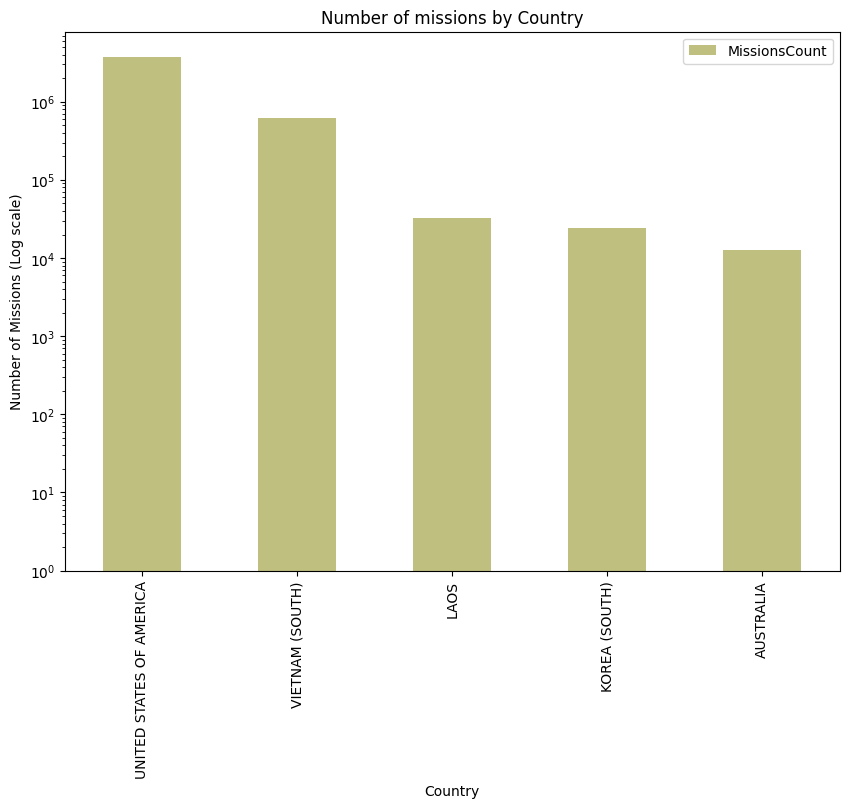

In [ ]:
pl = missions_count_pd.plot(kind="bar",
                            x="ContryFlyingMission", y="MissionsCount",
                            figsize=(10, 7), log=True, alpha=0.5, color="olive")
pl.set_xlabel("Country")
pl.set_ylabel("Number of Missions (Log scale)")
pl.set_title("Number of missions by Country")

----

## Pytanie 2: Wyświetlić liczbę ataków (misji) i kraj wykonujący te ataki w każdym dniu podczas wojny.

Keywords: `group by`, `parse date`, `plot`

Let's select the relevant columns:

In [ ]:
missions_countries = Bombing_Operations.selectExpr(["to_date(MissionDate) as MissionDate", "ContryFlyingMission"])
missions_countries

DataFrame[MissionDate: date, ContryFlyingMission: string]

In [ ]:
missions_countries.show()

+-----------+--------------------+
|MissionDate| ContryFlyingMission|
+-----------+--------------------+
| 1971-06-05|UNITED STATES OF ...|
| 1972-12-26|UNITED STATES OF ...|
| 1973-07-28|UNITED STATES OF ...|
| 1970-02-02|UNITED STATES OF ...|
| 1970-10-08|     VIETNAM (SOUTH)|
| 1970-11-25|UNITED STATES OF ...|
| 1972-03-08|UNITED STATES OF ...|
| 1971-12-27|UNITED STATES OF ...|
| 1972-05-24|UNITED STATES OF ...|
| 1972-09-12|UNITED STATES OF ...|
| 1974-06-13|UNITED STATES OF ...|
| 1974-12-19|UNITED STATES OF ...|
| 1973-10-24|     VIETNAM (SOUTH)|
| 1974-03-19|     VIETNAM (SOUTH)|
| 1970-05-08|UNITED STATES OF ...|
| 1971-05-12|UNITED STATES OF ...|
| 1971-12-03|UNITED STATES OF ...|
| 1971-12-19|                LAOS|
| 1972-08-18|UNITED STATES OF ...|
| 1972-10-15|UNITED STATES OF ...|
+-----------+--------------------+
only showing top 20 rows



The filed MissionDate is converted to a Python `date` object.

Now we can group by `MissionDate` and `ContryFlyingMission` to get the count:

In [ ]:
missions_by_date = missions_countries\
                    .groupBy(["MissionDate", "ContryFlyingMission"])\
                    .agg(count("*").alias("MissionsCount"))\
                    .sort(asc("MissionDate")).toPandas()
#missions_by_date.info

In [ ]:
missions_by_date.shape

(9703, 3)

In [ ]:
missions_by_date.head(20)

,MissionDate,ContryFlyingMission,MissionsCount
0,1965-10-01,UNITED STATES OF AMERICA,447
1,1965-10-02,UNITED STATES OF AMERICA,652
2,1965-10-03,UNITED STATES OF AMERICA,608
3,1965-10-04,UNITED STATES OF AMERICA,532
4,1965-10-05,UNITED STATES OF AMERICA,697
5,1965-10-05,VIETNAM (SOUTH),72
6,1965-10-06,UNITED STATES OF AMERICA,689
7,1965-10-06,VIETNAM (SOUTH),49
8,1965-10-07,VIETNAM (SOUTH),50
9,1965-10-07,UNITED STATES OF AMERICA,605


### Wyświetlić liczbę misji rozłożoną w czasie dla każdego kraju.

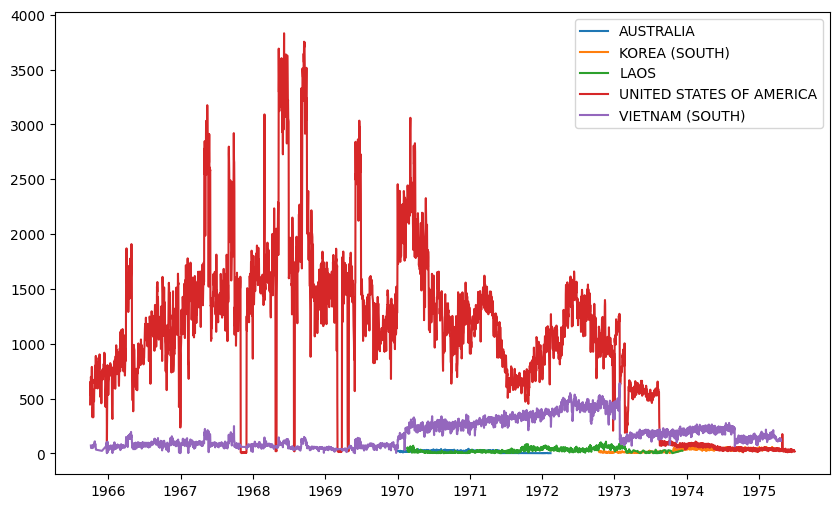

In [ ]:
fig = plt.figure(figsize=(10, 6))

# iterate the different groups to create a different series
for country, missions in missions_by_date.groupby("ContryFlyingMission"):
    plt.plot(missions["MissionDate"], missions["MissionsCount"], label=country)

plt.legend(loc='best')

We can observe how South Vietnam increased its missions starting from 1970. The drop in 1973 is motivated by the [Paris Peace Accords](https://en.wikipedia.org/wiki/Paris_Peace_Accords) that took place on January 27th, 1973, to establish peace in Vietnam and end the war.

----

##  Pytanie 4: Kto wykonuje misję w *North Vietnam* w danym dniu?

Keywords: `RDD map reduce` `cache` `save results`

> Indented block



In [ ]:
jun_25_operations = Bombing_Operations.where("MissionDate = '1966-06-25' AND TargetCountry='NORTH VIETNAM'")

Which coutries scheduled missions that day?

In [ ]:
jun_25_operations.groupBy("ContryFlyingMission").agg(count("*").alias("MissionsCount")).toPandas()

,ContryFlyingMission,MissionsCount
0,VIETNAM (SOUTH),2
1,UNITED STATES OF AMERICA,323


In [ ]:
jun_25_operations.show()

+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------+-------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|    WeaponType|WeaponsLoadedWeight|
+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------+-------------------+
|   EF-10|UNITED STATES OF ...| 1966-06-25|      ROLLING THUN|          N|         DANANG|NORTH VIETNAM|      1920.0|          NULL|                 -1|
|     F-4|UNITED STATES OF ...| 1966-06-25|      ROLLING THUN|          N|        UBON AB|NORTH VIETNAM|      1915.0|          NULL|                 -1|
|     A-4|UNITED STATES OF ...| 1966-06-25|      ROLLING THUN|          N|  CONSTELLATION|NORTH VIETNAM|      1152.0| 2.75IN HE RKT|                 -1|
|     F-4|UNITED STATES OF ...| 1966-06-25|      ROLLING THUN|          N|        

### Zapisać wyniki w pamięci (cache)

In [ ]:
jun_25_operations.cache()

DataFrame[AirCraft: string, ContryFlyingMission: string, MissionDate: string, OperationSupported: string, PeriodOfDay: string, TakeoffLocation: string, TargetCountry: string, TimeOnTarget: double, WeaponType: string, WeaponsLoadedWeight: bigint]

Now you can count the number of rows and move the content to the cache:

In [ ]:
%time jun_25_operations.count()

CPU times: user 152 ms, sys: 15.9 ms, total: 168 ms
Wall time: 19.3 s


325

The second time the content is cached and the operation is much faster:

In [ ]:
%time jun_25_operations.count()

CPU times: user 4.87 ms, sys: 115 µs, total: 4.98 ms
Wall time: 231 ms


325

You can also save the results on a file...

In [ ]:
jun_25_operations.write.mode('overwrite').json("jun_25_operations.json")

... and read from the file:

In [ ]:
jun_25_operations = spark.read.json("jun_25_operations.json")

We can use the simple DataFrame API...

In [ ]:
TakeoffLocationCounts = jun_25_operations\
                            .groupBy("TakeoffLocation").agg(count("*").alias("MissionsCount"))\
                            .sort(desc("MissionsCount"))
TakeoffLocationCounts.show()

+---------------+-------------+
|TakeoffLocation|MissionsCount|
+---------------+-------------+
|  CONSTELLATION|           92|
|        UBON AB|           57|
|         RANGER|           49|
|          KORAT|           37|
|         TAKHLI|           36|
|         DANANG|           21|
|       UDORN AB|           20|
|   TAN SON NHUT|           11|
|   CAM RANH BAY|            2|
+---------------+-------------+



### Obliczenie równoległe:  Map/Reduce  na RDDs.

First we emit a pair in the format (Location, 1):

In [ ]:
all_locations = jun_25_operations.rdd.map(lambda row: (row.TakeoffLocation, 1))
all_locations.take(3)

[('DANANG', 1), ('UBON AB', 1), ('CONSTELLATION', 1)]

Then, we sum counters in the reduce step, and we sort by count:

In [ ]:
locations_counts_rdd = all_locations.reduceByKey(lambda a, b: a+b).sortBy(lambda r: -r[1])
locations_counts_rdd.take(3)

[('CONSTELLATION', 92), ('UBON AB', 57), ('RANGER', 49)]

Now we can convert the RDD in dataframe by mapping the pairs to objects of type `Row`

In [ ]:
locations_counts_with_schema = locations_counts_rdd.map(lambda r: Row(TakeoffLocation=r[0], MissionsCount=r[1]))
locations_counts = spark.createDataFrame(locations_counts_with_schema)
locations_counts.show()

+---------------+-------------+
|TakeoffLocation|MissionsCount|
+---------------+-------------+
|  CONSTELLATION|           92|
|        UBON AB|           57|
|         RANGER|           49|
|          KORAT|           37|
|         TAKHLI|           36|
|         DANANG|           21|
|       UDORN AB|           20|
|   TAN SON NHUT|           11|
|   CAM RANH BAY|            2|
+---------------+-------------+



## Pytanie 5: Który typ maszyny najczęściej jest używany w misjach?
(maksymalna liczba misji)

Keywords: `join` `group by`

Let's check the content of `Aircraft_Glossary`:

In [ ]:
Aircraft_Glossary.show(5)

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
+--------+--------------------+--------------------+
only showing top 5 rows



We are interested in the filed `AirCraftType`.

In [ ]:
Bombing_Operations.select("AirCraft").show(5)

+--------+
|AirCraft|
+--------+
|   EC-47|
|   EC-47|
|    RF-4|
|     A-1|
|    A-37|
+--------+
only showing top 5 rows



We can join on the column `AirCraft` of both dataframes.

With Dataframe API:

In [ ]:
missions_joined = Bombing_Operations.join(Aircraft_Glossary,
                                          Bombing_Operations.AirCraft == Aircraft_Glossary.AirCraft)
missions_joined

DataFrame[AirCraft: string, ContryFlyingMission: string, MissionDate: string, OperationSupported: string, PeriodOfDay: string, TakeoffLocation: string, TargetCountry: string, TimeOnTarget: double, WeaponType: string, WeaponsLoadedWeight: bigint, AirCraft: string, AirCraftName: string, AirCraftType: string]

We can select only the field we are interested in:

In [ ]:
missions_aircrafts = missions_joined.select("AirCraftType")
missions_aircrafts.show(5)

+--------------------+
|        AirCraftType|
+--------------------+
|Military Transpor...|
|Military Transpor...|
|  Fighter bomber jet|
|         Fighter Jet|
|Light ground-atta...|
+--------------------+
only showing top 5 rows



And finally we can group by `AirCraftType` and count:

In [ ]:
missions_aircrafts.groupBy("AirCraftType").agg(count("*").alias("MissionsCount"))\
                  .sort(desc("MissionsCount"))\
                  .show()

+--------------------+-------------+
|        AirCraftType|MissionsCount|
+--------------------+-------------+
|  Fighter Jet Bomber|      1073126|
|         Fighter Jet|       882594|
|  Jet Fighter Bomber|       451385|
|     Attack Aircraft|       315246|
|Light ground-atta...|       267457|
|  Fighter bomber jet|       242231|
|Military Transpor...|       228426|
|  Utility Helicopter|       146653|
|    Strategic bomber|        99100|
|     Tactical Bomber|        82219|
|Observation Aircraft|        81820|
|Fixed wing ground...|        75058|
|Ground attack air...|        73843|
|Carrier-based Fig...|        58691|
|   Training Aircraft|        48435|
|       Light fighter|        39999|
|        Light Bomber|        39262|
|Light Tactical Bo...|        34738|
| Light Utility Plane|        28582|
|Observation/ Ligh...|        24491|
+--------------------+-------------+
only showing top 20 rows



In alternative we can rewrite this in pure SQL:

In [ ]:
Bombing_Operations.registerTempTable("Bombing_Operations")
Aircraft_Glossary.registerTempTable("Aircraft_Glossary")

query = """
SELECT AirCraftType, count(*) MissionsCount
FROM Bombing_Operations bo
JOIN Aircraft_Glossary ag
ON bo.AirCraft = ag.AirCraft
GROUP BY AirCraftType
ORDER BY MissionsCount DESC
"""

spark.sql(query).show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+--------------------+-------------+
|        AirCraftType|MissionsCount|
+--------------------+-------------+
|  Fighter Jet Bomber|      1073126|
|         Fighter Jet|       882594|
|  Jet Fighter Bomber|       451385|
|     Attack Aircraft|       315246|
|Light ground-atta...|       267457|
|  Fighter bomber jet|       242231|
|Military Transpor...|       228426|
|  Utility Helicopter|       146653|
|    Strategic bomber|        99100|
|     Tactical Bomber|        82219|
|Observation Aircraft|        81820|
|Fixed wing ground...|        75058|
|Ground attack air...|        73843|
|Carrier-based Fig...|        58691|
|   Training Aircraft|        48435|
|       Light fighter|        39999|
|        Light Bomber|        39262|
|Light Tactical Bo...|        34738|
| Light Utility Plane|        28582|
|Observation/ Ligh...|        24491|
+--------------------+-------------+
only showing top 20 rows



The aircrafts of type `Fighter Jet Bomber` participated in most of the missions in the Vietnam war.

Note: This dataset would require further cleaning and normalization. See `Fighter Jet Bomber`, `Jet Fighter Bomber`, `Fighter bomber jet`

### Pytanie 6: Wyświetlić  liczbę misji do każdego z krajów docelowych  (*TargetCountry*).

In [ ]:
missions_per_country = Bombing_Operations.groupBy("TargetCountry").agg(count("MissionDate").alias("LiczbaMisji"))

missions_per_country.show()

+--------------+-----------+
| TargetCountry|LiczbaMisji|
+--------------+-----------+
|      CAMBODIA|     218788|
|WESTPAC WATERS|         74|
| SOUTH VIETNAM|    2172403|
|       UNKNOWN|         59|
|   PHILLIPINES|          1|
|      THAILAND|      60486|
| NORTH VIETNAM|     694269|
|          LAOS|    1254695|
+--------------+-----------+



### Pytanie 7: Wyświetlić wynik pytania 6 za pomocą histogramu

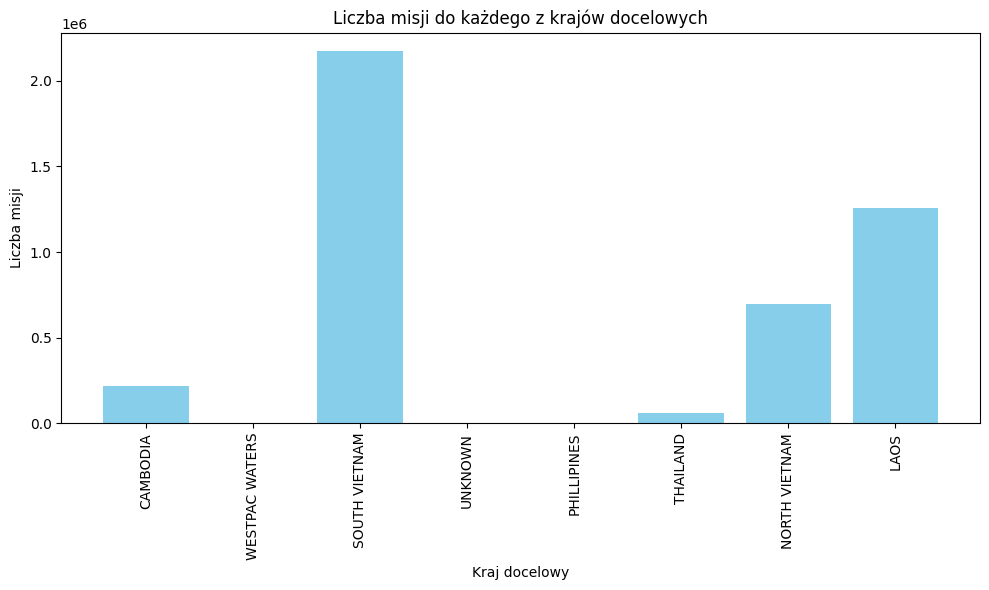

In [ ]:
result_list = missions_per_country.collect()

countries = [row['TargetCountry'] for row in result_list]
missions_count = [row['LiczbaMisji'] for row in result_list]

plt.figure(figsize=(10, 6))
plt.bar(countries, missions_count, color='skyblue')
plt.xlabel('Kraj docelowy')
plt.ylabel('Liczba misji')
plt.title('Liczba misji do każdego z krajów docelowych')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

###Pytanie 8: Wyświetlić (*MissionCount*) w okresie od 1/06/1966-31/12/1968.

In [ ]:
filtered_missions = Bombing_Operations.filter((col("MissionDate") >= "1966-06-01") & (col("MissionDate") <= "1968-12-31"))

mission_count_in_period = filtered_missions.count()

print("Liczba misji w okresie od 1/06/1966 do 31/12/1968:", mission_count_in_period)

Liczba misji w okresie od 1/06/1966 do 31/12/1968: 1565220


### Pytanie 9: Wizualizować wynik (w pyt. 8) na wykresie (*MissionCount  vs. MissionDate*).

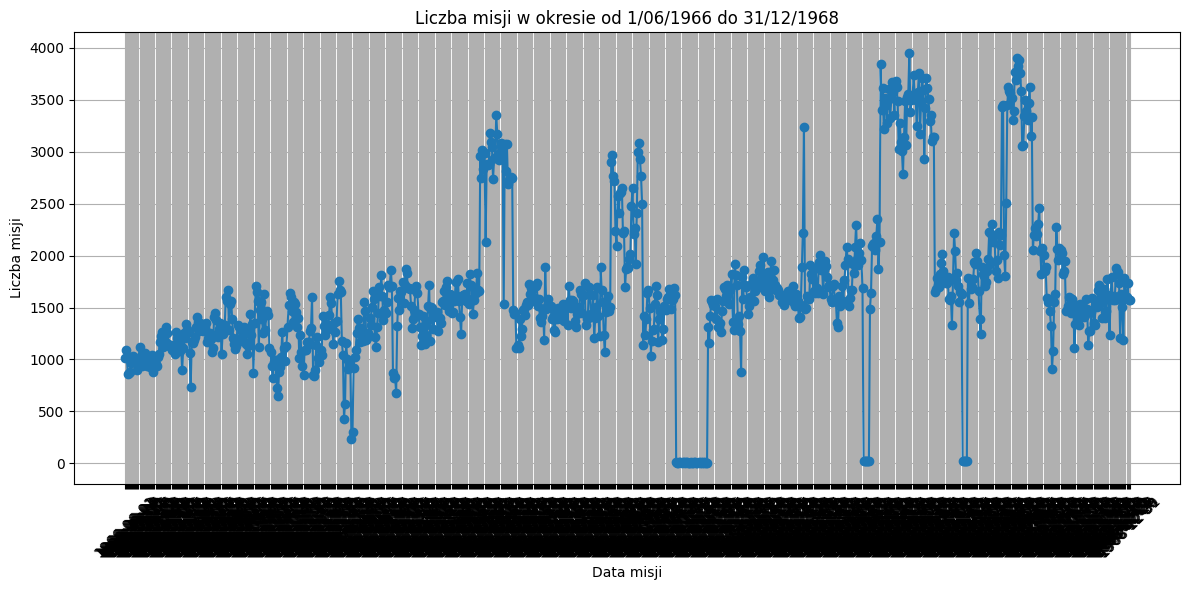

In [ ]:
missions_per_date = filtered_missions.groupBy("MissionDate").count().orderBy("MissionDate")

result_list = missions_per_date.collect()

dates = [row['MissionDate'] for row in result_list]
mission_counts = [row['count'] for row in result_list]

plt.figure(figsize=(12, 6))
plt.plot(dates, mission_counts, marker='o', linestyle='-')
plt.title('Liczba misji w okresie od 1/06/1966 do 31/12/1968')
plt.xlabel('Data misji')
plt.ylabel('Liczba misji')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

### Pytanie 10: Jaki typ maszyny (*AirCraftType*) najczęściej jest używany na danym docelowym kraju (*TargetCountry*)?

In [ ]:
most_used_aircraft_per_country = Bombing_Operations.groupBy("TargetCountry", "AirCraft").count()

most_used_aircraft_per_country = most_used_aircraft_per_country.orderBy("TargetCountry", desc("count")).dropDuplicates(["TargetCountry"])

most_used_aircraft_per_country.show()

+--------------+--------+------+
| TargetCountry|AirCraft| count|
+--------------+--------+------+
|      CAMBODIA|     F-4| 31686|
|          LAOS|     F-4|368799|
| NORTH VIETNAM|     F-4|189853|
|   PHILLIPINES|    RF-8|     1|
| SOUTH VIETNAM|   F-100|414141|
|      THAILAND|     F-4|  8744|
|       UNKNOWN|     A-7|    16|
|WESTPAC WATERS|  EC-121|    20|
+--------------+--------+------+



# Zadanie 1

In [ ]:
arrivals_per_country = Bombing_Operations.groupBy("TargetCountry").agg(count("*").alias("MissionCount"))

arrivals_per_country = arrivals_per_country.orderBy(desc("MissionCount"))

most_arrivals_country = arrivals_per_country.first()

arrivals_per_country.show()

print("Kraj z największą liczbą przylotów:", most_arrivals_country["TargetCountry"], "z", most_arrivals_country["MissionCount"], "przylotami.")

+--------------+------------+
| TargetCountry|MissionCount|
+--------------+------------+
| SOUTH VIETNAM|     2172403|
|          LAOS|     1254695|
| NORTH VIETNAM|      694269|
|      CAMBODIA|      218788|
|      THAILAND|       60486|
|WESTPAC WATERS|          74|
|       UNKNOWN|          59|
|   PHILLIPINES|           1|
+--------------+------------+

Kraj z największą liczbą przylotów: SOUTH VIETNAM z 2172403 przylotami.


# Zadanie 2

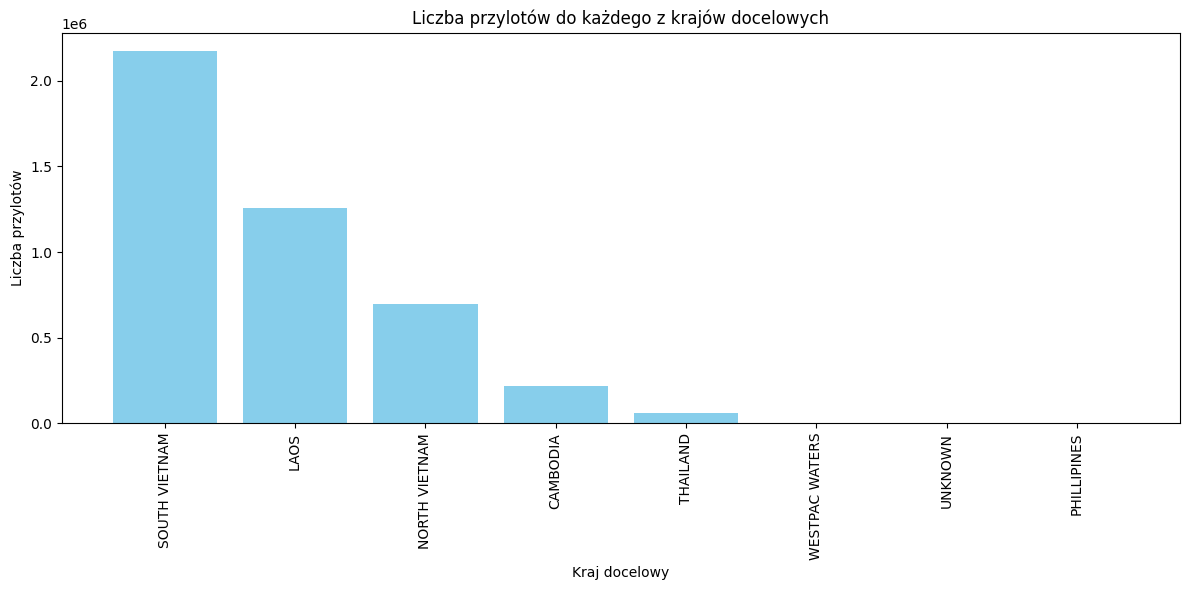

In [ ]:
result_list = arrivals_per_country.collect()

countries = [row['TargetCountry'] for row in result_list]
missions_count = [row['MissionCount'] for row in result_list]

plt.figure(figsize=(12, 6))
plt.bar(countries, missions_count, color='skyblue')
plt.xlabel('Kraj docelowy')
plt.ylabel('Liczba przylotów')
plt.title('Liczba przylotów do każdego z krajów docelowych')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

# Zadanie 3

In [ ]:
unique_target_countries = Bombing_Operations.select("TargetCountry").distinct().count()
print(f"Liczba unikalnych krajów docelowych (TargetCountry): {unique_target_countries}")

selected_country = 'NORTH VIETNAM'

aircraft_operations = Bombing_Operations.filter(col("TargetCountry") == selected_country) \
                                          .groupBy("AirCraft") \
                                          .count() \
                                          .orderBy(col("count").desc())

aircraft_operations.show()

most_common_aircraft = aircraft_operations.first()
print(f"Najczęściej używany typ samolotu w {selected_country}: {most_common_aircraft['AirCraft']}, Liczba operacji: {most_common_aircraft['count']}")

Liczba unikalnych krajów docelowych (TargetCountry): 8
+--------+------+
|AirCraft| count|
+--------+------+
|     F-4|189853|
|     A-4|124064|
|   F-105| 72556|
|     A-6| 56327|
|     A-7| 50540|
|    RF-4| 42453|
|   EB-66| 25395|
|     A-1| 23800|
|  RF-101| 20855|
|     F-8| 17440|
|    B-52|  7756|
|    RA-5|  7490|
|   EF-10|  6172|
|    EA-3|  6121|
|    RF-8|  5200|
|    EA-1|  4854|
|    B-57|  4828|
|    EA-6|  3497|
|   F-111|  3466|
|  EC-121|  3093|
+--------+------+
only showing top 20 rows

Najczęściej używany typ samolotu w NORTH VIETNAM: F-4, Liczba operacji: 189853


# Zadanie 4

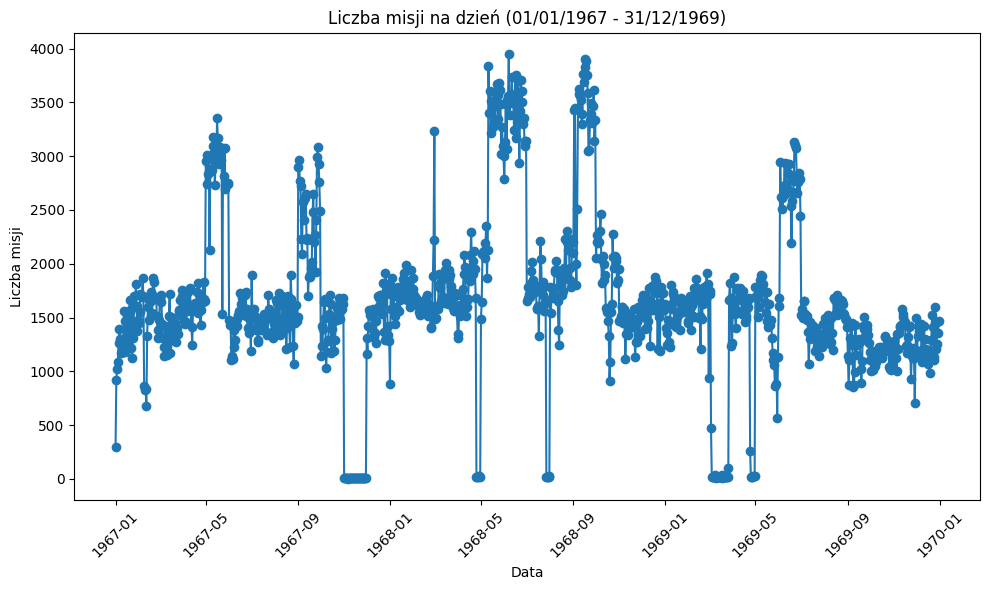

Dzień z największą liczbą misji: 1968-06-07, Liczba misji: 3950


In [ ]:
Bombing_Operations = Bombing_Operations.withColumn("MissionDate", to_date(col("MissionDate"), "yyyy-MM-dd"))

filtered_Bombing_Operations = Bombing_Operations.filter((col("MissionDate") >= lit("1967-01-01")) & (col("MissionDate") <= lit("1969-12-31")))

missions_per_day = filtered_Bombing_Operations.groupBy("MissionDate").count().orderBy("MissionDate")

missions_pd = missions_per_day.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(missions_pd["MissionDate"], missions_pd["count"], marker='o', linestyle='-')
plt.title('Liczba misji na dzień (01/01/1967 - 31/12/1969)')
plt.xlabel('Data')
plt.ylabel('Liczba misji')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

max_missions_day = missions_per_day.orderBy(col("count").desc()).first()
print(f"Dzień z największą liczbą misji: {max_missions_day['MissionDate']}, Liczba misji: {max_missions_day['count']}")

# Zadanie 5

In [ ]:
selected_country_target = 'NORTH VIETNAM'

top_takeoff_location = Bombing_Operations.filter(col("TargetCountry") == selected_country_target) \
                                          .groupBy("TakeoffLocation") \
                                          .count() \
                                          .orderBy(col("count").desc()) \
                                          .first()

print(f"Z {top_takeoff_location['TakeoffLocation']} wystartowało najwięcej samolotów w kierunku {selected_country_target}, Łączna liczba startów: {top_takeoff_location['count']}")

aircraft_types_from_top_location = Bombing_Operations.filter((col("TargetCountry") == selected_country_target) &
                                                              (col("TakeoffLocation") == top_takeoff_location['TakeoffLocation'])) \
                                                     .groupBy("AirCraft") \
                                                     .count() \
                                                     .orderBy(col("count").desc())

aircraft_types_from_top_location.show()

Z DANANG wystartowało najwięcej samolotów w kierunku NORTH VIETNAM, Łączna liczba startów: 71267
+--------+-----+
|AirCraft|count|
+--------+-----+
|     F-4|39460|
|     A-6| 8728|
|   EF-10| 6170|
|    EA-3| 3505|
|    EA-6| 3323|
|    B-57| 2579|
|     F-8| 2439|
|  EC-121| 2253|
|    RF-4| 1038|
|     A-1|  585|
|   F-100|  435|
|    EP-3|  196|
|    TA-4|  166|
|   F-104|   89|
|     TF9|   80|
|   C-130|   76|
|   AC-47|   49|
|     F-5|   24|
|   F-105|   15|
|    RF-8|   11|
+--------+-----+
only showing top 20 rows

